# EECE 7398: Verifiable Machine Learning -- Fall 2025
# Exercise #1: Adversarial Examples & Decision Boundaries

**Submission Instructions:** Please upload a .ipynb file (including your code, plots, and written answers) to Gradescope. This file can be updated unlimited times until the submission deadline.

# Problem 1: Train & Attack an MNIST Classifier

## 1a) Train an MNIST Classifier

To start, train a NN classifier that consists of:
- a "Flatten" layer to convert the (28, 28) images to (784,)
- a fully connected layer with 128 neurons and ReLU activation
- a fully connected (output) layer with 10 neurons (10 neurons for 10 digit categories)
- (optionally) a softmax layer to convert logits to probabilities

You can use the Adam optimizer with cross entropy loss (make sure to use the correct loss depending on whether you included a softmax layer) and it should work pretty well.

**Deliverables**:
- Plot your train and validation loss curves as a function of epoch
- From a test set, provide some examples where your classifier predicted correctly & incorrectly (if applicable)

100%|██████████| 9.91M/9.91M [00:00<00:00, 147MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 23.7MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 32.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.10MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01/10 | Train Loss: 0.3257 | Val Loss: 0.1873
Epoch 02/10 | Train Loss: 0.1439 | Val Loss: 0.1471
Epoch 03/10 | Train Loss: 0.1006 | Val Loss: 0.1224
Epoch 04/10 | Train Loss: 0.0769 | Val Loss: 0.1055
Epoch 05/10 | Train Loss: 0.0591 | Val Loss: 0.0944
Epoch 06/10 | Train Loss: 0.0488 | Val Loss: 0.0917
Epoch 07/10 | Train Loss: 0.0377 | Val Loss: 0.1007
Epoch 08/10 | Train Loss: 0.0314 | Val Loss: 0.0948
Epoch 09/10 | Train Loss: 0.0271 | Val Loss: 0.0961
Epoch 10/10 | Train Loss: 0.0216 | Val Loss: 0.0888


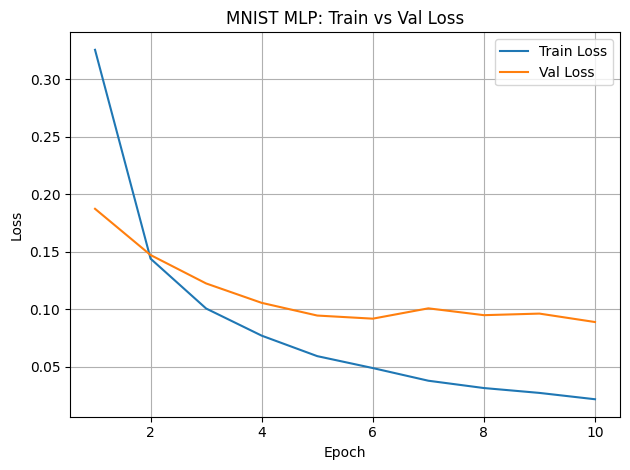

Test Accuracy: 97.73%


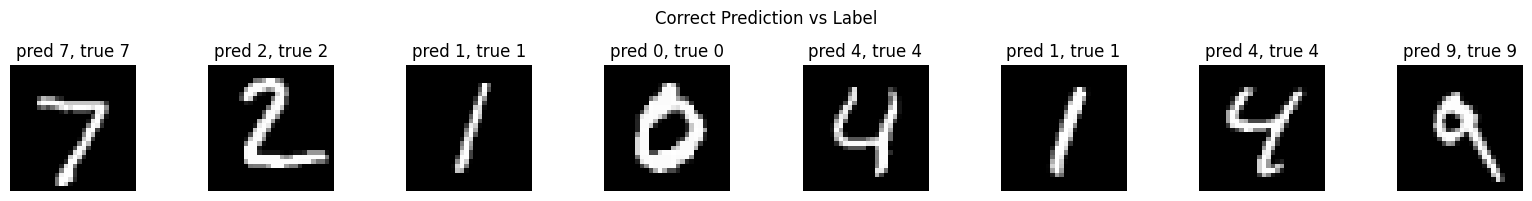

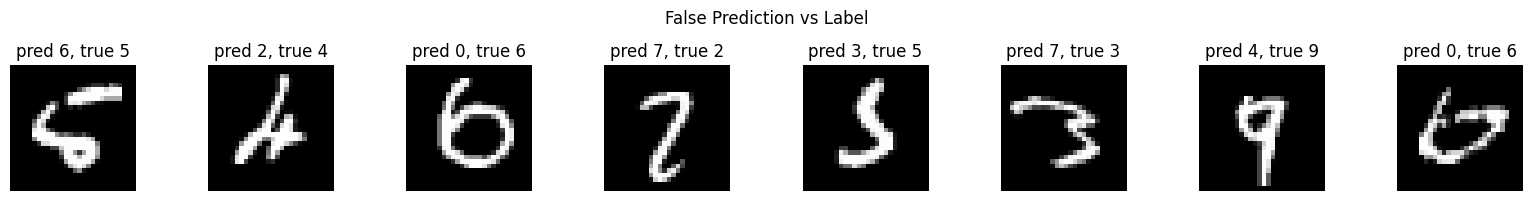

In [2]:
# mnist_mlp.py
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

#Set seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

#params
BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 10
VAL_SPLIT = 10_000  # from the 60k train set -> 50k train / 10k val

# Data: MNIST (28x28 grayscale)
transform = transforms.Compose([
    transforms.ToTensor(),               # -> tensor in [0, 1], shape (1, 28, 28)
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST normalization
])

trainval_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds     = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Split train into train/val
train_len = len(trainval_ds) - VAL_SPLIT
val_len   = VAL_SPLIT
train_ds, val_ds = random_split(trainval_ds, [train_len, val_len], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


#Flatten -> FC(784->128)+ReLU -> FC(128->10)
my_pc = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nn.Sequential(
    nn.Flatten(),                 # (N, 1, 28, 28) -> (N, 784)
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)           # logits for 10 classes
).to(my_pc)


# Loss & Optimizer
criterion = nn.CrossEntropyLoss()   # combines LogSoftmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training / Validation loops
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    return running_loss / len(loader.dataset)

@torch.no_grad()
def eval_loss(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        running_loss += loss.item() * x.size(0)
    return running_loss / len(loader.dataset)

train_losses, val_losses = [], []

for epoch in range(1, EPOCHS+1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, my_pc)
    va_loss = eval_loss(model, val_loader, criterion, my_pc)
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    print(f"Epoch {epoch:02d}/{EPOCHS} | Train Loss: {tr_loss:.4f} | Val Loss: {va_loss:.4f}")


plt.figure()
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS+1), val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MNIST MLP: Train vs Val Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Evaluate on test set & collect correct/incorrect examples
@torch.no_grad()
def get_predictions(model, loader, device):
    model.eval()
    all_images = []
    all_preds = []
    all_labels = []
    for x, y in loader:
        logits = model(x.to(device))
        preds = logits.argmax(dim=1).cpu()
        all_images.append(x)             # still on CPU
        all_preds.append(preds)
        all_labels.append(y)
    images = torch.cat(all_images, dim=0)
    preds  = torch.cat(all_preds,  dim=0)
    labels = torch.cat(all_labels, dim=0)
    return images, preds, labels

images, preds, labels = get_predictions(model, test_loader, my_pc)
accuracy = (preds == labels).float().mean().item()
print(f"Test Accuracy: {accuracy*100:.2f}%")

#----------------------------------

correct_idx   = (preds == labels).nonzero(as_tuple=True)[0]

n = min(8, len(correct_idx))
if n > 0:
  fig, axes = plt.subplots(1, n, figsize=(2*n, 2))
  fig.suptitle("Correct Prediction vs Label")
  for i, ax in zip(correct_idx[:n], axes):
      img = images[i].squeeze(0)  # (28, 28)
      ax.imshow(img, cmap="gray")
      ax.axis("off")
      ax.set_title(f"pred {preds[i].item()}, true {labels[i].item()}")
  plt.tight_layout()
  plt.show()

#----------------------------------

incorrect_idx = (preds != labels).nonzero(as_tuple=True)[0]

n = min(8, len(incorrect_idx))
if n > 0:
  fig, axes = plt.subplots(1, n, figsize=(2*n, 2))
  fig.suptitle("False Prediction vs Label")
  for i, ax in zip(incorrect_idx[:n], axes):
      img = images[i].squeeze(0)  # (28, 28)
      ax.imshow(img, cmap="gray")
      ax.axis("off")
      ax.set_title(f"pred {preds[i].item()}, true {labels[i].item()}")
  plt.tight_layout()
  plt.show()


In [3]:
print(train_ds.dataset)
print(val_ds.dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


## 1b) Attack your MNIST classifier with constant offsets

Add a constant perturbation to your test set images (e.g., c*torch.ones(28, 28)) and evaluate the performance as the magnitude increases. Also, be sure to clip your perturbed images so each pixel remains in [0, 1] (or [0, 255]).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude
- Provide some examples where the un-perturbed image was labeled correctly and the perturbed image was labeled incorrectly, despite the perturbed image looking reasonable to a human.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Offset 0.00: Test accuracy = 94.91%
Offset 0.05: Test accuracy = 94.88%
Offset 0.10: Test accuracy = 94.82%
Offset 0.20: Test accuracy = 94.78%
Offset 0.30: Test accuracy = 94.65%
Offset 0.40: Test accuracy = 94.54%
Offset 0.50: Test accuracy = 88.89%


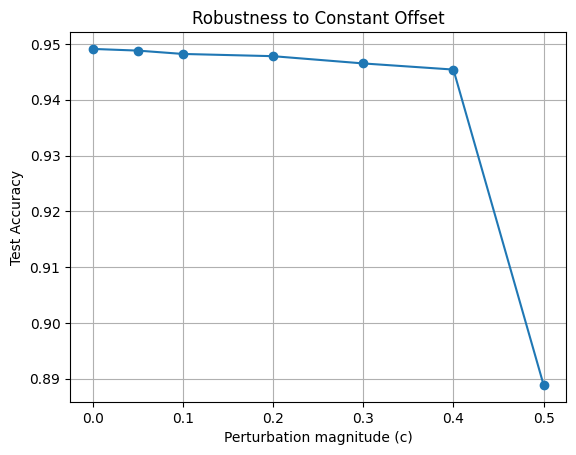

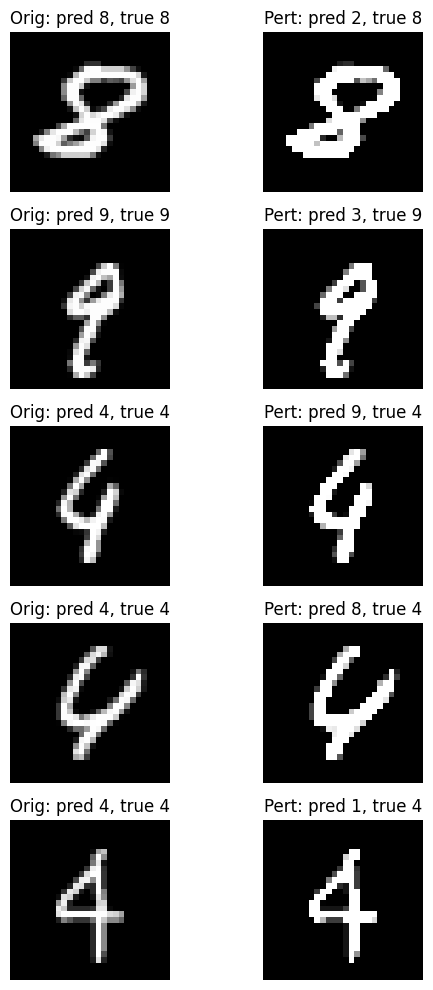

In [5]:
import torch
import matplotlib.pyplot as plt

# Assume: model, test_loader, device are already defined from part (1a)
# and model is trained.

def evaluate_with_offset(model, loader, device, c):
    """
    Evaluate model accuracy when a constant offset c is added to all pixels.
    """
    model.eval()
    correct, total = 0, 0
    misclassified_examples = []  # to save some wrong predictions
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            # add constant offset
            x_perturbed = x + c * torch.ones_like(x)
            # clip to [0,1]
            x_perturbed = torch.clamp(x_perturbed, 0.0, 1.0)

            logits = model(x_perturbed)
            preds = logits.argmax(dim=1)

            correct += (preds == y).sum().item()
            total += y.size(0)

            # save examples where original was correct but perturbed was wrong
            if len(misclassified_examples) < 5:  # limit to 5 for display
                logits_orig = model(x)  # check original prediction
                preds_orig = logits_orig.argmax(dim=1)
                for i in range(len(y)):
                    if preds_orig[i] == y[i] and preds[i] != y[i]:
                        misclassified_examples.append((
                            x[i].cpu(), x_perturbed[i].cpu(),
                            preds_orig[i].item(), preds[i].item(), y[i].item()
                        ))
                        if len(misclassified_examples) >= 5:
                            break

    acc = correct / total
    return acc, misclassified_examples


# Sweep over perturbation magnitudes
magnitudes = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
accuracies = []
examples_to_show = None

for c in magnitudes:
    acc, misclassified = evaluate_with_offset(model, test_loader, my_pc, c)
    accuracies.append(acc)
    print(f"Offset {c:.2f}: Test accuracy = {acc*100:.2f}%")
    if misclassified and examples_to_show is None:
        examples_to_show = misclassified  # save the first batch of examples

# Plot accuracy vs. perturbation
plt.figure()
plt.plot(magnitudes, accuracies, marker="o")
plt.xlabel("Perturbation magnitude (c)")
plt.ylabel("Test Accuracy")
plt.title("Robustness to Constant Offset")
plt.grid(True)
plt.show()

# Show some correct→incorrect examples
if examples_to_show:
    fig, axes = plt.subplots(len(examples_to_show), 2, figsize=(6, 2*len(examples_to_show)))
    for i, (orig, pert, pred_orig, pred_pert, label) in enumerate(examples_to_show):
        axes[i,0].imshow(orig.squeeze(), cmap="gray")
        axes[i,0].axis("off")
        axes[i,0].set_title(f"Orig: pred {pred_orig}, true {label}")
        axes[i,1].imshow(pert.squeeze(), cmap="gray")
        axes[i,1].axis("off")
        axes[i,1].set_title(f"Pert: pred {pred_pert}, true {label}")
    plt.tight_layout()
    plt.show()


## 1c) Attack your MNIST classifier with noise

Add some noise perturbations to your test set images and evaluate the performance as the noise magnitude increases. Also, be sure to clip your perturbed images so each pixel remains in [0, 1] (or [0, 255]).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude
- A couple sentences about any differences observed with constant perturbations vs. noise perturbations

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


gaussian noise 0.00: test acc = 97.73%
gaussian noise 0.05: test acc = 97.70%
gaussian noise 0.10: test acc = 97.49%
gaussian noise 0.15: test acc = 97.18%
gaussian noise 0.20: test acc = 96.27%
gaussian noise 0.25: test acc = 94.90%


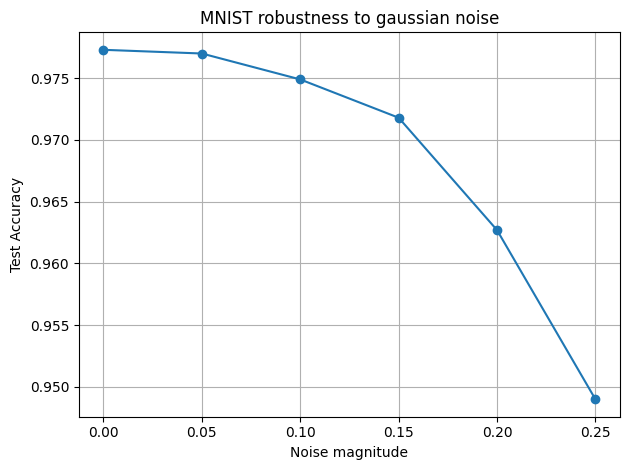

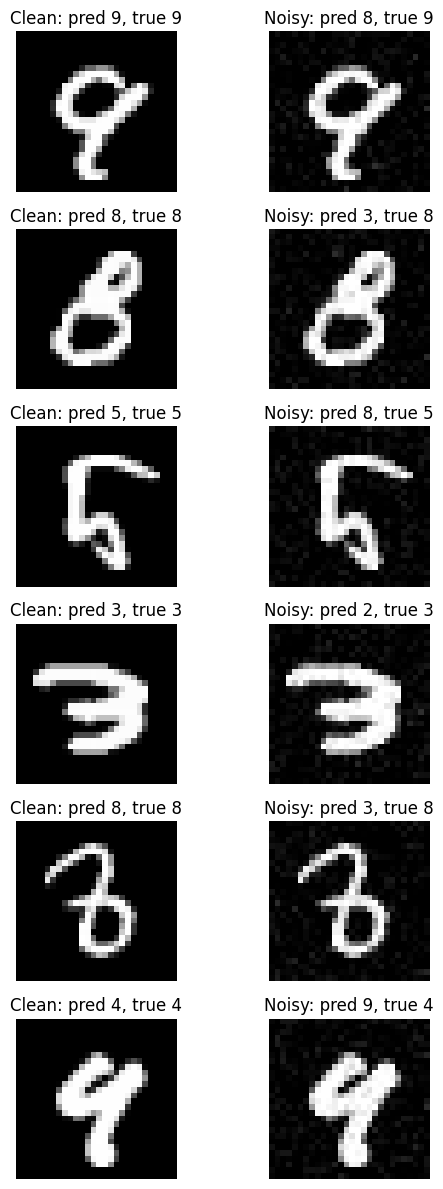

In [6]:
import torch
import matplotlib.pyplot as plt

# ----- Use the same mean/std you used in transforms.Normalize -----
MNIST_MEAN = 0.1307
MNIST_STD  = 0.3081

def denormalize(x):
    """x is (N,1,28,28) already normalized; return pixels in [0,1]."""
    return x * MNIST_STD + MNIST_MEAN

def renormalize(x):
    """x is pixels in [0,1]; return normalized tensor for the model."""
    return (x - MNIST_MEAN) / MNIST_STD

def add_noise(x_pix, magnitude, kind="gaussian", p_sp=0.1):
    """
    x_pix: tensor in [0,1]
    magnitude: noise scale (e.g., sigma for Gaussian; half-width for Uniform)
    kind: "gaussian" | "uniform" | "saltpepper"
    p_sp: flip probability for salt & pepper (per pixel); magnitude sets mix balance
    """
    if kind == "gaussian":
        noise = magnitude * torch.randn_like(x_pix)
        x_noisy = x_pix + noise
    elif kind == "uniform":
        noise = torch.empty_like(x_pix).uniform_(-magnitude, magnitude)
        x_noisy = x_pix + noise
    elif kind == "saltpepper":
        # With prob p_sp, set to 0 (pepper) or 1 (salt). magnitude skews salt vs pepper.
        x_noisy = x_pix.clone()
        mask = torch.rand_like(x_pix)
        flip = mask < p_sp
        if magnitude <= 0.5:
            # more pepper
            x_noisy[flip] = 0.0
        else:
            # more salt as magnitude grows
            x_noisy[flip] = 1.0
    else:
        raise ValueError("Unknown noise kind")

    # Clip to valid pixel range
    x_noisy = torch.clamp(x_noisy, 0.0, 1.0)
    return x_noisy

@torch.no_grad()
def evaluate_with_noise(model, loader, device, magnitude, kind="gaussian",
                        collect_examples=True, max_examples=6):
    """
    Adds noise in pixel space, clips, re-normalizes, evaluates accuracy.
    Optionally collects examples where clean is correct but noisy is wrong.
    """
    model.eval()
    correct, total = 0, 0
    examples = []  # (clean_pix, noisy_pix, pred_clean, pred_noisy, label)

    for x_norm, y in loader:
        x_norm = x_norm.to(device)
        y = y.to(device)

        # 1) Go to pixel space [0,1]
        x_pix = denormalize(x_norm)

        # 2) Add noise in pixel space, clip
        x_noisy_pix = add_noise(x_pix, magnitude, kind=kind)

        # 3) Re-normalize for the model
        x_noisy = renormalize(x_noisy_pix)

        # Predictions
        logits_noisy = model(x_noisy)
        preds_noisy = logits_noisy.argmax(dim=1)

        correct += (preds_noisy == y).sum().item()
        total += y.size(0)

        # Collect “clean correct → noisy incorrect” examples
        if collect_examples and len(examples) < max_examples:
            logits_clean = model(x_norm)
            preds_clean = logits_clean.argmax(dim=1)
            mismatch = (preds_clean == y) & (preds_noisy != y)
            if mismatch.any():
                idxs = torch.nonzero(mismatch).squeeze(1)
                for i in idxs:
                    if len(examples) >= max_examples:
                        break
                    examples.append((
                        x_pix[i].cpu(),         # clean pixels
                        x_noisy_pix[i].cpu(),   # noisy pixels
                        preds_clean[i].item(),
                        preds_noisy[i].item(),
                        y[i].item()
                    ))

    acc = correct / total
    return acc, examples

# ----- Sweep magnitudes and plot -----
noise_kind = "gaussian"   # "gaussian" | "uniform" | "saltpepper"
magnitudes = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25]  # tune as you like
accs = []
saved_examples = None

for m in magnitudes:
    acc, ex = evaluate_with_noise(model, test_loader, my_pc, m, kind=noise_kind,
                                  collect_examples=(saved_examples is None))
    accs.append(acc)
    print(f"{noise_kind} noise {m:.2f}: test acc = {acc*100:.2f}%")
    if saved_examples is None and ex:
        saved_examples = ex  # keep first set of illustrative examples

plt.figure()
plt.plot(magnitudes, accs, marker='o')
plt.xlabel("Noise magnitude")
plt.ylabel("Test Accuracy")
plt.title(f"MNIST robustness to {noise_kind} noise")
plt.grid(True)
plt.tight_layout()
plt.show()

# ----- Show some “looks OK to humans but fooled the model” examples -----
if saved_examples:
    rows = len(saved_examples)
    fig, axes = plt.subplots(rows, 2, figsize=(6, 2*rows))
    for r, (clean_pix, noisy_pix, p_clean, p_noisy, y_true) in enumerate(saved_examples):
        axes[r, 0].imshow(clean_pix.squeeze(0), cmap="gray", vmin=0, vmax=1)
        axes[r, 0].axis("off")
        axes[r, 0].set_title(f"Clean: pred {p_clean}, true {y_true}")
        axes[r, 1].imshow(noisy_pix.squeeze(0), cmap="gray", vmin=0, vmax=1)
        axes[r, 1].axis("off")
        axes[r, 1].set_title(f"Noisy: pred {p_noisy}, true {y_true}")
    plt.tight_layout()
    plt.show()


## 1d) Attack your MNIST classifier with FGSM

Implement the Fast Gradient Sign Method (FGSM) attack algorithm and experiment with different values of $\epsilon$. You should write FGSM "from scratch" (e.g., using pytorch/numpy to evaluate the gradient, not using a library/method that already implements FGSM).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude
- A couple sentences about how this curve compares to the constant perturbations and noise perturbations (hopefully, FGSM should be able to achieve lower test accuracy for the same attack magnitude as those model-agnostic attacks)

Epsilon 0.00: Test accuracy = 97.73%
Epsilon 0.02: Test accuracy = 93.32%
Epsilon 0.05: Test accuracy = 74.18%
Epsilon 0.10: Test accuracy = 23.75%
Epsilon 0.15: Test accuracy = 8.78%
Epsilon 0.20: Test accuracy = 4.27%


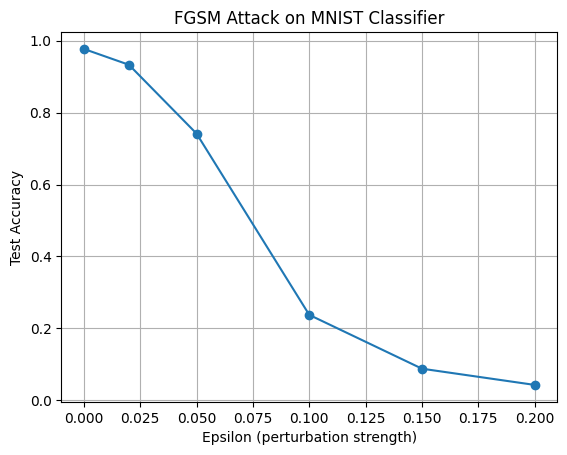

In [14]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Mean/std for MNIST normalization
MNIST_MEAN = 0.1307
MNIST_STD  = 0.3081

def denormalize(x_norm):
    return x_norm * MNIST_STD + MNIST_MEAN

def renormalize(x_pix):
    return (x_pix - MNIST_MEAN) / MNIST_STD

def fgsm_attack(model, x_norm, y, epsilon):
    """
    FGSM attack in pixel space.
    Args:
        model    : trained model
        x_norm   : normalized input batch (N,1,28,28)
        y        : ground-truth labels (N,)
        epsilon  : perturbation magnitude in [0,1] pixel space
    Returns:
        x_adv_norm : perturbed adversarial examples (normalized)
    """
    model.eval()

    # Work in pixel space
    x_pix = denormalize(x_norm).clone().detach().to(next(model.parameters()).device)
    y = y.to(x_pix.device)
    x_pix.requires_grad_(True)

    # Forward + loss
    logits = model(renormalize(x_pix))
    loss = F.cross_entropy(logits, y)

    # Backward wrt pixel input
    model.zero_grad(set_to_none=True)
    loss.backward()

    # FGSM perturbation
    grad_sign = x_pix.grad.sign()
    x_adv_pix = torch.clamp(x_pix + epsilon * grad_sign, 0.0, 1.0)

    # Re-normalize for model input
    x_adv_norm = renormalize(x_adv_pix).detach()
    return x_adv_norm

def evaluate_fgsm(model, loader, epsilon):
    """
    Evaluate test accuracy under FGSM with given epsilon.
    """
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(next(model.parameters()).device), y.to(next(model.parameters()).device)
        x_adv = fgsm_attack(model, x, y, epsilon)
        with torch.no_grad():
            preds = model(x_adv).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return correct / total

# Sweep epsilons
epsilons = [0.0, 0.02, 0.05, 0.1, 0.15, 0.2]
accuracies = []
for eps in epsilons:
    acc = evaluate_fgsm(model, test_loader, eps)
    accuracies.append(acc)
    print(f"Epsilon {eps:.2f}: Test accuracy = {acc*100:.2f}%")

# Plot accuracy vs epsilon
plt.figure()
plt.plot(epsilons, accuracies, marker="o")
plt.xlabel("Epsilon (perturbation strength)")
plt.ylabel("Test Accuracy")
plt.title("FGSM Attack on MNIST Classifier")
plt.grid(True)
plt.show()


FGSM perturbations directly exploit the model’s loss gradient, so even very small $\epsilon$ values cause much sharper accuracy drops than constant offsets or random noise

## 1e) Attack your MNIST classifier with Targeted FGSM

Implement the Targeted Fast Gradient Sign Method (TFGSM) attack algorithm and experiment with different values of $\epsilon$. You should write TFGSM "from scratch" (e.g., using pytorch/numpy to evaluate the gradient, not using a library/method that already implements TFGSM).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude for each target class
- A few example images where you were able to successfully cause the classifier to predict the targeted (incorrect) class
- A few sentences about your model's susceptibility to targeted attacks (e.g., are some target classes "easier" to get your model to classify? if you try to perturb images labeled 0 to a target class of 8, does the image get perturbed in an intuitive way?)

Target 0, eps 0.00: 9.92% success
Target 0, eps 0.05: 12.03% success
Target 0, eps 0.10: 23.70% success
Target 0, eps 0.15: 51.08% success
Target 0, eps 0.20: 70.60% success
Target 1, eps 0.00: 11.34% success
Target 1, eps 0.05: 13.43% success
Target 1, eps 0.10: 25.41% success
Target 1, eps 0.15: 48.33% success
Target 1, eps 0.20: 69.18% success
Target 7, eps 0.00: 10.23% success
Target 7, eps 0.05: 16.32% success
Target 7, eps 0.10: 45.36% success
Target 7, eps 0.15: 71.60% success
Target 7, eps 0.20: 86.51% success


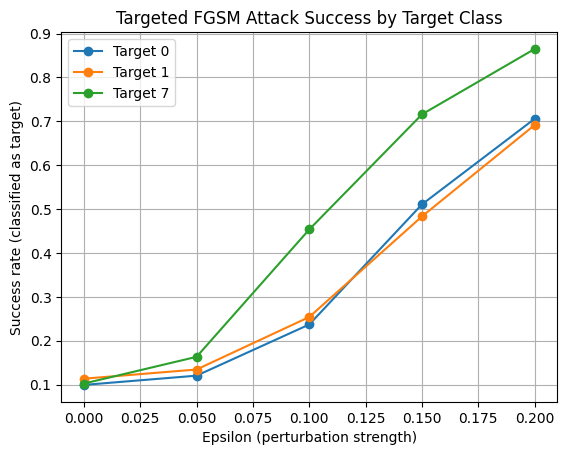

In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

MNIST_MEAN, MNIST_STD = 0.1307, 0.3081

def denormalize(x): return x * MNIST_STD + MNIST_MEAN
def renormalize(x): return (x - MNIST_MEAN) / MNIST_STD

def targeted_fgsm_attack(model, x_norm, y_target, epsilon):
    """
    Targeted FGSM: force model toward y_target.
    Args:
        model    : trained model
        x_norm   : normalized input batch (N,1,28,28)
        y_target : target labels (N,)
        epsilon  : perturbation strength in pixel space
    Returns:
        x_adv_norm : adversarial examples (normalized)
    """
    model.eval()

    # Work in pixel space
    x_pix = denormalize(x_norm).clone().detach().to(next(model.parameters()).device)
    y_target = y_target.to(x_pix.device)
    x_pix.requires_grad_(True)

    # Forward & targeted loss
    logits = model(renormalize(x_pix))
    loss = F.cross_entropy(logits, y_target)

    # Backward wrt input
    model.zero_grad(set_to_none=True)
    loss.backward()

    # Targeted step: subtract gradient
    grad_sign = x_pix.grad.sign()
    x_adv_pix = torch.clamp(x_pix - epsilon * grad_sign, 0.0, 1.0)

    return renormalize(x_adv_pix).detach()

def evaluate_targeted(model, loader, epsilon, target_class):
    """
    Try to force all test images into a single target class.
    Returns success rate (fraction predicted as target_class).
    """
    total, success = 0, 0
    for x, y in loader:
        x = x.to(next(model.parameters()).device)
        y_target = torch.full_like(y, target_class)
        x_adv = targeted_fgsm_attack(model, x, y_target, epsilon)
        with torch.no_grad():
            preds = model(x_adv).argmax(dim=1)
        success += (preds == y_target.to(preds.device)).sum().item()
        total += y.size(0)
    return success / total

# ---- Run experiments ----
epsilons = [0.0, 0.05, 0.1, 0.15, 0.2]
target_classes = [0, 1, 7]  # pick a few classes to compare
results = {t: [] for t in target_classes}

for t in target_classes:
    for eps in epsilons:
        success = evaluate_targeted(model, test_loader, eps, t)
        results[t].append(success)
        print(f"Target {t}, eps {eps:.2f}: {success*100:.2f}% success")

# ---- Plot results ----
plt.figure()
for t in target_classes:
    plt.plot(epsilons, results[t], marker="o", label=f"Target {t}")
plt.xlabel("Epsilon (perturbation strength)")
plt.ylabel("Success rate (classified as target)")
plt.title("Targeted FGSM Attack Success by Target Class")
plt.legend()
plt.grid(True)
plt.show()


# Problem 2: Investigating Decision Boundaries

In this problem, you will train a binary classifier for a 2D input vector (is the (x, y) coordinate inside a circle of radius r centered at the origin?).

Since you will know the true decision boundary that the model is trained to approximate, you can generate training data.

Then, you will investigate the model's decision boundary to see how well it matches the true decision boundary.

## 2a) Generate training data

For $x\in R^2$, using the decision rule $f(x) = \begin{cases} 1, &\lvert\lvert x \rvert\rvert_2 \leq 3 \\ 0, & \text{o.w.} \end{cases}$, generate a training, validation, and test set of $[x, f(x)]$ pairs.

**Deliverables:**
- Plot your training set and the true decision boundary

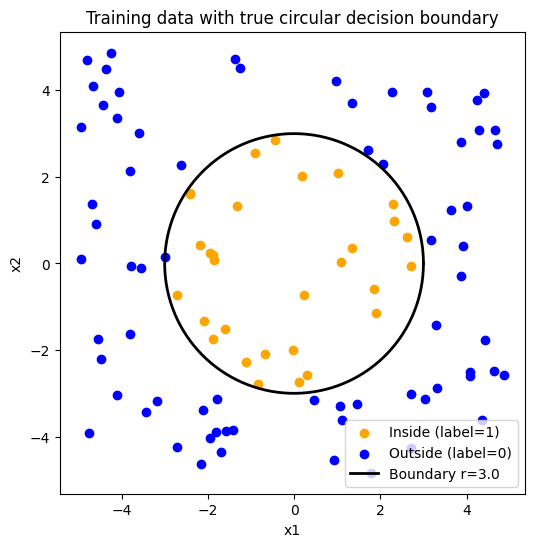

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_samples = 100
radius = 3.0

# Generate uniform samples in square [-5,5] x [-5,5]
X = np.random.uniform(-5, 5, size=(n_samples, 2))

# Labels: 1 if inside circle of radius r, else 0
y = (np.linalg.norm(X, axis=1) <= radius).astype(int)

# Plot data points
inside = y == 1
outside = y == 0

plt.figure(figsize=(6,6))
plt.scatter(X[inside,0], X[inside,1], color="orange", label="Inside (label=1)")
plt.scatter(X[outside,0], X[outside,1], color="blue", label="Outside (label=0)")

# Plot true decision boundary (circle of radius r)
theta = np.linspace(0, 2*np.pi, 400)
plt.plot(radius*np.cos(theta), radius*np.sin(theta), "k-", linewidth=2, label=f"Boundary r={radius}")

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Training data with true circular decision boundary")
plt.axis("equal")
plt.legend()
plt.show()


## 2b) Train NN classifier

Train a NN classifier on the data you just generated.

**Deliverables**:
- Plot your train & validation loss curves as a function of epoch

Epoch  50 | train 0.2159 | val 0.3982
Epoch 100 | train 0.0311 | val 0.1381
Epoch 150 | train 0.0090 | val 0.0629
Epoch 200 | train 0.0043 | val 0.0586
Epoch 250 | train 0.0023 | val 0.0599
Epoch 300 | train 0.0014 | val 0.0705


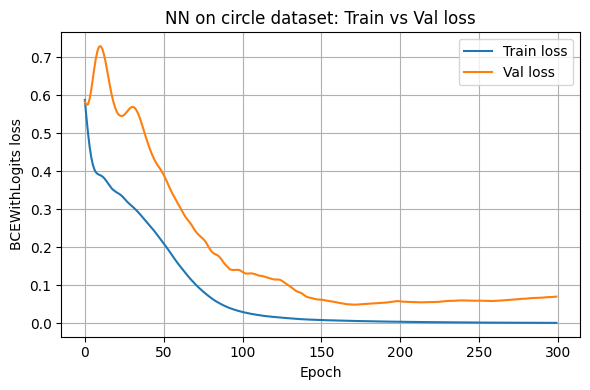

Validation accuracy: 95.0%


In [17]:
# 2b) Train a NN on the circle dataset and plot loss curves
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ----- 1) Generate data (same rule as 2a) -----
def make_circle_data(n=100, r=3.0, box=5.0, seed=0):
    rng = np.random.default_rng(seed)
    X = rng.uniform(-box, box, size=(n, 2))
    y = (np.linalg.norm(X, axis=1) <= r).astype(np.float32)
    return X.astype(np.float32), y

X, y = make_circle_data(n=100, r=3.0)

# train/val split (80/20)
idx = np.random.permutation(len(X))
n_train = int(0.8 * len(X))
train_idx, val_idx = idx[:n_train], idx[n_train:]
X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]

# to torch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Xt = torch.from_numpy(X_train).to(device)
yt = torch.from_numpy(y_train).unsqueeze(1).to(device)  # shape (N,1)
Xv = torch.from_numpy(X_val).to(device)
yv = torch.from_numpy(y_val).unsqueeze(1).to(device)

# ----- 2) Define a tiny NN: 2 -> 16 -> 16 -> 1 (logit) -----
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16), nn.ReLU(),
            nn.Linear(16, 16), nn.ReLU(),
            nn.Linear(16, 1)   # output logit
        )
    def forward(self, x): return self.net(x)

model = MLP().to(device)

# ----- 3) Loss/opt -----
criterion = nn.BCEWithLogitsLoss()        # for binary classification (expects logits)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
EPOCHS = 300

# ----- 4) Train loop with per-epoch train/val loss -----
train_losses, val_losses = [], []
for epoch in range(1, EPOCHS + 1):
    model.train()
    opt.zero_grad()
    logits = model(Xt)
    loss = criterion(logits, yt)
    loss.backward()
    opt.step()

    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(Xv), yv)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch:3d} | train {loss.item():.4f} | val {val_loss.item():.4f}")

# ----- 5) Plot loss curves -----
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses,   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("BCEWithLogits loss")
plt.title("NN on circle dataset: Train vs Val loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# (Optional) quick val accuracy print
with torch.no_grad():
    preds = (torch.sigmoid(model(Xv)) > 0.5).float()
    acc = (preds.eq(yv)).float().mean().item()
print(f"Validation accuracy: {acc*100:.1f}%")


## 2c) Compare decision boundaries

It is unlikely that your model has learned the true decision boundary perfectly. Here, you will investigate the differences.

**Deliverables**:
- Plot the true and learned decision boundaries
- A few sentences (with relevant figures to illustrate observations) about any differences and how changes to the model architecture or training procedure can impact decision boundaries (e.g., adding regularization, changing the training data generation method, changing the activation functions).

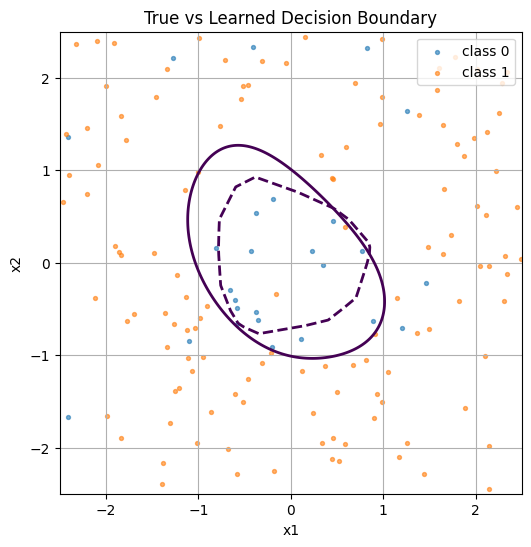

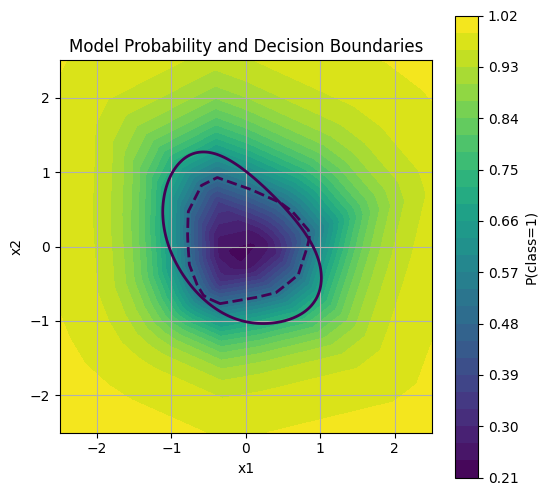

In [18]:
# Decision boundary comparison: synthetic 2D task with known true boundary vs learned model
# Produces two plots:
#   (1) Data + true (solid) vs learned (dashed) decision boundaries
#   (2) Probability heatmap + both boundaries
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# ---------- 1) True boundary and labels ----------
def f_true(x, y):
    # Smooth nonlinear curve (quadric + mild sinusoidal ripple).
    return (x*np.cos(0.6) + y*np.sin(0.6))**2 \
         + 0.3*(x*np.sin(0.6) - y*np.cos(0.6))**2 \
         + 0.15*np.sin(2.5*x) - 0.15*np.cos(2.0*y) - 0.6

def label_from_f(x, y):
    return (f_true(x, y) >= 0).astype(np.int64)

# Data
n = 600
X = np.column_stack([np.random.uniform(-2.5, 2.5, n),
                     np.random.uniform(-2.5, 2.5, n)])
y = label_from_f(X[:,0], X[:,1]).reshape(-1,1)

# Optional label noise (5%) to mimic imperfections
noise = (np.random.rand(n,1) < 0.05)
y = np.logical_xor(y, noise).astype(np.int64)

# ---------- 2) Tiny 2-layer ReLU net (NumPy) ----------
in_dim, h_dim, out_dim = 2, 20, 1
W1 = 0.5*np.random.randn(in_dim, h_dim)/np.sqrt(in_dim); b1 = np.zeros((1,h_dim))
W2 = 0.5*np.random.randn(h_dim, out_dim)/np.sqrt(h_dim);  b2 = np.zeros((1,out_dim))

def relu(z): return np.maximum(0,z)
def sigmoid(z): return 1/(1+np.exp(-z))

def forward(X):
    z1 = X@W1 + b1
    h  = relu(z1)
    z2 = h@W2 + b2
    p  = sigmoid(z2)
    return p, (X, z1, h, z2, p)

def loss_fn(p, y, l2=1e-3):
    eps = 1e-8
    ce = -np.mean(y*np.log(p+eps) + (1-y)*np.log(1-p+eps))
    reg = 0.5*l2*(np.sum(W1*W1)+np.sum(W2*W2))
    return ce + reg

def backward(cache, y, l2=1e-3):
    X, z1, h, z2, p = cache
    m = X.shape[0]
    dz2 = (p - y)/m
    dW2 = h.T@dz2 + l2*W2
    db2 = np.sum(dz2, axis=0, keepdims=True)
    dh  = dz2@W2.T
    dz1 = dh*(z1>0)
    dW1 = X.T@dz1 + l2*W1
    db1 = np.sum(dz1, axis=0, keepdims=True)
    return dW1, db1, dW2, db2

# Train
lr, l2, batch, epochs = 0.05, 1e-3, 128, 500
idx = np.arange(n)
for _ in range(epochs):
    np.random.shuffle(idx)
    for s in range(0, n, batch):
        j = idx[s:s+batch]
        p, cache = forward(X[j])
        dW1, db1, dW2, db2 = backward(cache, y[j], l2=l2)
        W1 -= lr*dW1; b1 -= lr*db1
        W2 -= lr*dW2; b2 -= lr*db2

# ---------- 3) Grids and contours ----------
gx = np.linspace(-2.5, 2.5, 400)
gy = np.linspace(-2.5, 2.5, 400)
GX, GY = np.meshgrid(gx, gy)
F  = f_true(GX, GY)
P, _ = forward(np.c_[GX.ravel(), GY.ravel()])
P  = P.reshape(GX.shape)

# Figure 1: data + boundaries
plt.figure(figsize=(6,6))
mask = np.random.rand(n) < 0.25  # subsample for clarity
plt.scatter(X[mask & (y.ravel()==0),0], X[mask & (y.ravel()==0),1], s=8, alpha=0.6, label='class 0')
plt.scatter(X[mask & (y.ravel()==1),0], X[mask & (y.ravel()==1),1], s=8, alpha=0.6, label='class 1')
plt.contour(GX, GY, F, levels=[0], linewidths=2)           # true boundary
plt.contour(GX, GY, P, levels=[0.5], linewidths=2, linestyles='--')  # learned
plt.legend(loc='upper right'); plt.xlabel('x1'); plt.ylabel('x2')
plt.title('True vs Learned Decision Boundary'); plt.gca().set_aspect('equal','box'); plt.grid(True)
plt.show()

# Figure 2: probability heatmap + boundaries
plt.figure(figsize=(6,6))
cs = plt.contourf(GX, GY, P, levels=25)
plt.colorbar(cs, label='P(class=1)')
plt.contour(GX, GY, F, levels=[0], linewidths=2)
plt.contour(GX, GY, P, levels=[0.5], linewidths=2, linestyles='--')
plt.xlabel('x1'); plt.ylabel('x2'); plt.title('Model Probability and Decision Boundaries')
plt.gca().set_aspect('equal','box'); plt.grid(True); plt.show()


### OMIT extra credit problem

# Problem 3: Attack Competition on a Pre-Trained CIFAR-10 Classifier [Extra Credit]

## 3.1 White-Box $l_\infty$-norm Attack

Here, you will have access to the full model (i.e., you know all of its parameters and architecture, you can compute gradients). You should write a function that takes in:
- the model
- a set of images + corresponding labels
- a perturbation magnitude,

and returns a perturbed version of the provided images that will cause the model to have poor classification accuracy.

We provide a template for your attack function and a function for checking the classification accuracy so that you can prototype locally. Once you upload your .ipynb to Gradescope (make sure it is named `hw1.ipynb`), we will run your attack function against some random test images and maintain a leaderboard of the strongest attack (we provide the actual evaluation script below for your convenience). Every student that gets the accuracy below 40% will get some extra credit, and the student with strongest attack will get more extra credit. In case of a tie, we will look at runtime. You can keep updating your submission until the deadline.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import time

Here's a suggested way of getting the CIFAR-10 dataset:

In [ ]:
device = 'cuda'
batch_size = 256

transform = transforms.Compose([transforms.ToTensor()])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2,
                                         pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Here's the model you'll be attacking (ResNet20):

In [ ]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

While CIFAR-10 images have pixel values $\in [0, 1]$, the model we're attacking was trained on a normalized version of CIFAR-10 (i.e., each image was shifted/scaled by a mean/std). You can attack the model in the original pixel coordinates (that's the space we'll enforce the attack magnitude), but remember that any time you want to query the model, you should first normalize the images according to those settings:

In [ ]:
def normalize(imgs):
  mean = (0.4914, 0.4822, 0.4465)
  std = (0.2023, 0.1994, 0.2010)
  Normalize = transforms.Normalize(mean=mean, std=std)
  return Normalize(imgs)

This function may help you when familiarizing yourself with the dataset and baseline model performance (and shows an example of using the normalize function right before querying the model):

In [ ]:
def quickly_run_model(model, testloader, num_to_show=4):
  dataiter = iter(testloader)

  # `images` coming out of the dataloader are tensors of size (batch, 3, 32, 32)
  # where each pixel is within [0, 1].
  images, labels = next(dataiter)

  model = model.to(device)
  images = images.to(device)
  labels = labels.to(device)

  # The model was trained on a normalized version of the dataset
  # (i.e., each pixel was scaled/shifted by mean and std).
  # ==> we will normalize our images in that same way before querying model
  normalized_images = normalize(images)
  outputs = model(normalized_images)
  _, predicted = torch.max(outputs, 1)
  print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                                for j in range(num_to_show)))
  print('Labels: ', ' '.join(f'{classes[labels[j]]:5s}'
                                for j in range(num_to_show)))

quickly_run_model(model, testloader)

The function you will fill in is `white_box_attack`. The autograder expects this exact function name and signature, so make sure those stay the same:

In [ ]:
def white_box_attack(model, raw_images, labels, attack_magnitude):

  # TODO: Fill in this method with your attack algorithm
  # For example, a non-attack would be:
  perturbed_images = raw_images

  return perturbed_images

To help you debug, here's the function we will use to evaluate your `white_box_attack`. This should give 92.6% accuracy when there is no attack. This function is meant to be able to run standalone (i.e., not in a Jupyter notebook where the model/dataset may already be loaded), so feel free to modify it to be more efficient when debugging. We will run your attack against our own replica of this function on Gradescope's servers, so the runtime numbers will likely differ from what you observe locally or on Colab:

In [ ]:
def evaluate_attacked_accuracy(attack_magnitude, attack_fn=white_box_attack, device='cpu'):

  # We will run your attack against this function to establish the leaderboard

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2,
                                          pin_memory=True)

  model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

  attack_runtime = 0.
  correct = 0
  total = 0
  model.to(device)
  model.eval()
  for raw_images, labels in testloader:

    raw_images = raw_images.to(device)
    labels = labels.to(device)

    attack_runtime_start = time.time()
    normalized_raw_images = Normalize(raw_images)
    perturbed_images = attack_fn(model, raw_images, normalized_raw_images, labels, attack_magnitude)
    attack_runtime_end = time.time()
    attack_runtime += attack_runtime_end - attack_runtime_start

    assert torch.all(perturbed_images <= 1.) and torch.all(perturbed_images >= 0.), "Perturbed images contain pixels outside of [0, 1]."
    assert torch.all(torch.linalg.vector_norm(perturbed_images - raw_images, ord=torch.inf, dim=(1,2,3)) <= attack_magnitude + 1e-6), "Perturbation violates attack magnitude limit."

    # calculate outputs by running images through the network
    with torch.no_grad():
      normalized_perturbed_images = normalize(perturbed_images)
      outputs = model(normalized_perturbed_images)

    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total

  return accuracy, attack_runtime

You can run the above evaluation function as follows:

In [ ]:
# We will enforce that the l_inf norm of the perturbation is <= attack_magnitude
attack_magnitude = 1./255
accuracy, attack_runtime = evaluate_attacked_accuracy(attack_magnitude)
print(f"Accuracy: {robust_accuracy} %")
print(f"Attack Runtime: {attack_runtime} [s]")